# Preliminaries

In [1]:
# !pip install umap
# !pip uninstall umap
!pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score, rand_score, normalized_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE
import umap.umap_ as umap

import tensorflow_datasets as tfds

# Data Loading

In [3]:
# Load the dataset
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

# Split into training and test sets
train_dataset = dataset["train"]

# Print dataset info
print(info)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/incomplete.FXFMMC_3.0.1/',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/exa

In [4]:
torch.cuda.is_available()

True

In [5]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 60.0MB/s]
100%|██████████| 58/58 [00:35<00:00,  1.64it/s]


# Questions

### Question 19

Even though the VGG network is trained on a different dataset, the way the architecture finds and uses features to classify images is data-agnostic. At a high-level, when VGG performs feature extraction, it looks for image features such as edges and textures. The deeper the network, the more abstract features VGG can detect (e.g. shapes, object vs. background). These features are universal across images. That is, every image has some notion of edges or shapes. This allows VGG to use the same methods for feature extraction on different images, and VGG is initially trained to extract features with the most discrminative power.

### Question 20

In the FeatureExtractor class, the code list(vgg.features) is a set of convolutional layers from the VGG model. At each subsequent convolutional layer, the model extracts more abstract features. For example, at the first layer, the model may extract low-level features, such as edges or corners. These features can be thought of as the basic building blocks of an image. Using the output from the first layer as the input for the next layer, the model may extract higher-level features, such as shape or parts of an object. With sufficient layers, the model extracts features at a high enough level such that these features are useful for classification.

By using nn.Sequential(), the model is ultimately constructed such that the image data is passed through a set of convolution layers. Average pooling is used for downsampling and smoothing. Next, Flatten is used to convert the features into a one-dimensional vector. Finally, this one-dimensional vector goes through vgg.classifier[0], the first part of the fully-connected layer from VGG16, to be used for classification.

### Question 21

TA: For determining number of pixels in original image, do we look at the entire dataset and sum up the pixels? Is the number of features the VGG network extracts per image just the shape? (i.e. 4096)

In [6]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


### Question 22

How to determine density or sparsity from 1-d vector? Number of 0's? Or look at 3670 x 4096 matrix?

In [7]:
# Define sparsity as the number of 0's divided by the number of elements
sparsity = np.count_nonzero(f_all == 0) / f_all.size
print(f"Sparsity: {sparsity}")

Sparsity: 6.65233310626703e-08


### Question 23

In [8]:
# Perform t-SNE
tsne = TSNE(n_components = 2, random_state = 0)
X_embedded = tsne.fit_transform(f_all)

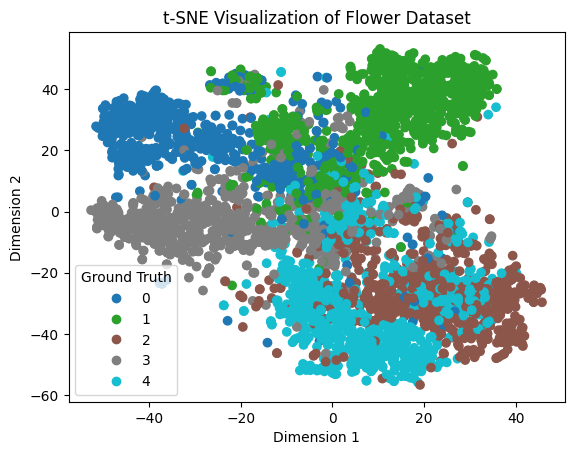

In [9]:
# Plot results
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y_all, cmap = 'tab10')
plt.title('t-SNE Visualization of Flower Dataset')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Create labels for legend
unique_labels = np.unique(y_all)
legend_labels = [f'Class {label}' for label in unique_labels]

# Add legend
plt.legend(*scatter.legend_elements(), title = "Ground Truth", loc = "best")

# Show plot
plt.show()

There appears appears to be a lot of overlap between groups 2 and 4. There is some overlap between groups 0 and 1. Otherwise, the groups are reasonably separated from each other based on these two dimensions alone.

### Question 24

In [10]:
# Compute Rand Index using
def compute_rand_index(feature_matrix: np.ndarray, labels: np.ndarray, method = str, minsamples = None, minclustersize = 5) -> float:
  """
  Computes the Rand Index for a given feature matrix and labels.

  Args:
    feature_matrix: A numpy array of shape (n_samples, n_features) containing the feature matrix.
    labels: A numpy array of shape (n_samples,) containing the ground truth labels.
    method: A string representing the clustering method to use. Can be either "kmeans" or "agglomerative" or "HDBSCAN" or "None.
    minsamples: An integer representing the minimum number of samples required to form a cluster. Only used for HDBSCAN.
    minclustersize: An integer representing the minimum cluster size. Only used for HDBSCAN.

  Returns:
    A float representing the Rand Index
  """

  # Number of clusters equal to number of unique labels
  n_clusters = len(np.unique(labels))

  if (method == "kmeans"):
    # Perform KMeans
    kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
    kmeans.fit(feature_matrix)
    cluster_labels = kmeans.labels_
  elif (method == "agglomerative"):
    # Perform Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters = n_clusters)
    agglomerative.fit(feature_matrix)
    cluster_labels = agglomerative.labels_
  elif (method == "HDBSCAN"):
    # Perform HDBSCAN
    hdbscan = HDBSCAN(min_samples = minsamples, min_cluster_size = minclustersize, metric = 'manhattan')
    hdbscan.fit(feature_matrix)
    cluster_labels = hdbscan.labels_
  elif (method == "None"):
    pass
  else:
    raise ValueError("Invalid clustering method. Must be either 'kmeans', 'agglomerative', 'HDBSCAN', or 'None'.")

  # Compute rand index
  rand_index = rand_score(labels, cluster_labels)

  return rand_index


In [11]:
# Dimensionality Reduction
# SVD
def svd_reduce(X: np.ndarray, n_components: int) -> np.ndarray:
  """
  Performs SVD on a given matrix.

  Args:
    X: A numpy array of shape (n_samples, n_features) containing the feature
    n_components: An integer representing the number of components to keep.

  Returns:
    A numpy array of shape (n_samples, n_components) containing the reduced feature matrix.
  """

  # Perform truncated SVD
  svd = TruncatedSVD(n_components = n_components)
  svd.fit(X)
  X_reduced = svd.transform(X)

  return X_reduced

# UMAP
def umap_reduce(X: np.ndarray, n_components: int) -> np.ndarray:
  """
  Performs UMAP on a given matrix.

  Args:
    X: A numpy array of shape (n_samples, n_features) containing the feature matrix.
    n_components: An integer representing the number of components to keep.

  Returns:
    A numpy array of shape (n_samples, n_components) containing the reduced feature matrix.
  """

  # Perform UMAP
  umap_reducer = umap.UMAP(n_components = n_components)
  X_reduced = umap_reducer.fit_transform(X)

  return X_reduced
  umap_reducer = umap.UMAP(n_components = n_components)
  X_reduced = umap_reducer.fit_transform(X)

  return X_reduced

In [12]:
# Dimensionality Reduction
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [13]:
# Create list of modules
dimensionality_reduction = ["None", "SVD", "UMAP", "Autoencoder"]
clutering = ["KMeans", "Agglomerative", "HDBSCAN"]
min_cluster_size = [10, 20, 30]
min_samples = [5, 10, 15]

# Create list of combinations of modules
modules = []
for dr in dimensionality_reduction:
    for c in clutering:
        if (c == "HDBSCAN"):
            for ms in min_samples:
                for mcs in min_cluster_size:
                    modules.append((dr, c, ms, mcs))
        else:
            modules.append((dr, c))

In [14]:
# KMeans very quick (<2 seconds)
# Agglomerative ok (~20 seconds)
# HDBSCAN slow (~3 minutes)
# Approximately 30 minutes to run

# Initialize rand index
rand_index_all = []

# Compute rand index for each module and keep track of progress

for module in tqdm(modules):
    print(f"Computing rand index for {module}")

    # Perform dimensionality reduction
    if (module[0] == "SVD"):
        f_all_reduced = svd_reduce(f_all, n_components = 50)
    elif (module[0] == "UMAP"):
        f_all_reduced = umap_reduce(f_all, n_components = 50)
    elif (module[0] == "Autoencoder"):
        f_all_reduced = Autoencoder(50).fit_transform(f_all)
    elif (module[0] == "None"):
        f_all_reduced = f_all
    else:
        raise ValueError("Invalid dimensionality reduction method. Must be either 'SVD', 'UMAP', or 'None'.")

    # Perform clustering
    if (module[1] == "KMeans"):
        rand_index = compute_rand_index(f_all_reduced, y_all, "kmeans")
        rand_index_all.append(rand_index)
    elif (module[1] == "Agglomerative"):
        rand_index = compute_rand_index(f_all_reduced, y_all, "agglomerative")
        rand_index_all.append(rand_index)
    elif (module[1] == "HDBSCAN"):
        rand_index = compute_rand_index(f_all_reduced, y_all, "HDBSCAN", module[2], module[3])
        rand_index_all.append(rand_index)


  0%|          | 0/44 [00:00<?, ?it/s]

Computing rand index for ('None', 'KMeans')


  2%|▏         | 1/44 [00:02<01:30,  2.11s/it]

Computing rand index for ('None', 'Agglomerative')


  5%|▍         | 2/44 [00:21<08:43, 12.46s/it]

Computing rand index for ('None', 'HDBSCAN', 5, 10)


  7%|▋         | 3/44 [02:47<50:01, 73.21s/it]

Computing rand index for ('None', 'HDBSCAN', 5, 20)


  9%|▉         | 4/44 [05:13<1:08:04, 102.10s/it]

Computing rand index for ('None', 'HDBSCAN', 5, 30)


 11%|█▏        | 5/44 [07:40<1:16:43, 118.05s/it]

Computing rand index for ('None', 'HDBSCAN', 10, 10)


 14%|█▎        | 6/44 [10:05<1:20:38, 127.33s/it]

Computing rand index for ('None', 'HDBSCAN', 10, 20)


 16%|█▌        | 7/44 [12:30<1:22:11, 133.29s/it]

Computing rand index for ('None', 'HDBSCAN', 10, 30)


 18%|█▊        | 8/44 [14:57<1:22:27, 137.44s/it]

Computing rand index for ('None', 'HDBSCAN', 15, 10)


 20%|██        | 9/44 [17:23<1:21:48, 140.24s/it]

Computing rand index for ('None', 'HDBSCAN', 15, 20)


 23%|██▎       | 10/44 [19:49<1:20:28, 142.01s/it]

Computing rand index for ('None', 'HDBSCAN', 15, 30)


 25%|██▌       | 11/44 [22:15<1:18:49, 143.32s/it]

Computing rand index for ('SVD', 'KMeans')


 27%|██▋       | 12/44 [22:17<53:30, 100.33s/it]  

Computing rand index for ('SVD', 'Agglomerative')


 30%|██▉       | 13/44 [22:20<36:32, 70.73s/it] 

Computing rand index for ('SVD', 'HDBSCAN', 5, 10)


 32%|███▏      | 14/44 [22:25<25:22, 50.75s/it]

Computing rand index for ('SVD', 'HDBSCAN', 5, 20)


 34%|███▍      | 15/44 [22:28<17:41, 36.60s/it]

Computing rand index for ('SVD', 'HDBSCAN', 5, 30)


 36%|███▋      | 16/44 [22:32<12:26, 26.67s/it]

Computing rand index for ('SVD', 'HDBSCAN', 10, 10)


 39%|███▊      | 17/44 [22:36<08:54, 19.80s/it]

Computing rand index for ('SVD', 'HDBSCAN', 10, 20)


 41%|████      | 18/44 [22:40<06:35, 15.21s/it]

Computing rand index for ('SVD', 'HDBSCAN', 10, 30)


 43%|████▎     | 19/44 [22:44<04:53, 11.72s/it]

Computing rand index for ('SVD', 'HDBSCAN', 15, 10)


 45%|████▌     | 20/44 [22:48<03:42,  9.26s/it]

Computing rand index for ('SVD', 'HDBSCAN', 15, 20)


 48%|████▊     | 21/44 [22:52<03:00,  7.83s/it]

Computing rand index for ('SVD', 'HDBSCAN', 15, 30)


 50%|█████     | 22/44 [22:56<02:24,  6.55s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing rand index for ('UMAP', 'KMeans')


 52%|█████▏    | 23/44 [23:37<06:00, 17.15s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing rand index for ('UMAP', 'Agglomerative')


 55%|█████▍    | 24/44 [24:13<07:30, 22.55s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing rand index for ('UMAP', 'HDBSCAN', 5, 10)


 57%|█████▋    | 25/44 [24:46<08:12, 25.92s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing rand index for ('UMAP', 'HDBSCAN', 5, 20)


 59%|█████▉    | 26/44 [25:19<08:24, 28.02s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing rand index for ('UMAP', 'HDBSCAN', 5, 30)


 61%|██████▏   | 27/44 [25:53<08:25, 29.71s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing rand index for ('UMAP', 'HDBSCAN', 10, 10)


 64%|██████▎   | 28/44 [26:27<08:14, 30.88s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing rand index for ('UMAP', 'HDBSCAN', 10, 20)


 66%|██████▌   | 29/44 [27:02<08:01, 32.12s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing rand index for ('UMAP', 'HDBSCAN', 10, 30)


 68%|██████▊   | 30/44 [27:37<07:43, 33.08s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing rand index for ('UMAP', 'HDBSCAN', 15, 10)


 70%|███████   | 31/44 [28:10<07:09, 33.02s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing rand index for ('UMAP', 'HDBSCAN', 15, 20)


 73%|███████▎  | 32/44 [28:44<06:39, 33.30s/it]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing rand index for ('UMAP', 'HDBSCAN', 15, 30)


 75%|███████▌  | 33/44 [29:16<06:04, 33.11s/it]

Computing rand index for ('Autoencoder', 'KMeans')



 77%|███████▋  | 34/44 [29:36<04:51, 29.17s/it]

Computing rand index for ('Autoencoder', 'Agglomerative')



 80%|███████▉  | 35/44 [29:57<03:58, 26.52s/it]

Computing rand index for ('Autoencoder', 'HDBSCAN', 5, 10)



 82%|████████▏ | 36/44 [30:18<03:19, 24.89s/it]

Computing rand index for ('Autoencoder', 'HDBSCAN', 5, 20)



 84%|████████▍ | 37/44 [30:39<02:46, 23.73s/it]

Computing rand index for ('Autoencoder', 'HDBSCAN', 5, 30)



 86%|████████▋ | 38/44 [31:00<02:17, 22.90s/it]

Computing rand index for ('Autoencoder', 'HDBSCAN', 10, 10)



 89%|████████▊ | 39/44 [31:22<01:53, 22.60s/it]

Computing rand index for ('Autoencoder', 'HDBSCAN', 10, 20)



 91%|█████████ | 40/44 [31:43<01:28, 22.17s/it]

Computing rand index for ('Autoencoder', 'HDBSCAN', 10, 30)



 93%|█████████▎| 41/44 [32:04<01:05, 21.84s/it]

Computing rand index for ('Autoencoder', 'HDBSCAN', 15, 10)



 95%|█████████▌| 42/44 [32:25<00:43, 21.58s/it]

Computing rand index for ('Autoencoder', 'HDBSCAN', 15, 20)



 98%|█████████▊| 43/44 [32:49<00:22, 22.23s/it]

Computing rand index for ('Autoencoder', 'HDBSCAN', 15, 30)



100%|██████████| 44/44 [33:10<00:00, 45.24s/it]


In [15]:
# Create dictionary of modules and rand_index
results_dict = {}
for i in range(len(modules)):
    results_dict[modules[i]] = rand_index_all[i]
results_dict

{('None', 'KMeans'): 0.7074858728740616,
 ('None', 'Agglomerative'): 0.7104411881564593,
 ('None', 'HDBSCAN', 5, 10): 0.41249915523165964,
 ('None', 'HDBSCAN', 5, 20): 0.20358404572368982,
 ('None', 'HDBSCAN', 5, 30): 0.20358404572368982,
 ('None', 'HDBSCAN', 10, 10): 0.20358404572368982,
 ('None', 'HDBSCAN', 10, 20): 0.20358404572368982,
 ('None', 'HDBSCAN', 10, 30): 0.20358404572368982,
 ('None', 'HDBSCAN', 15, 10): 0.20358404572368982,
 ('None', 'HDBSCAN', 15, 20): 0.20358404572368982,
 ('None', 'HDBSCAN', 15, 30): 0.20358404572368982,
 ('SVD', 'KMeans'): 0.7207804099892835,
 ('SVD', 'Agglomerative'): 0.6812510443564648,
 ('SVD', 'HDBSCAN', 5, 10): 0.42891506494876064,
 ('SVD', 'HDBSCAN', 5, 20): 0.20358404572368982,
 ('SVD', 'HDBSCAN', 5, 30): 0.20358404572368982,
 ('SVD', 'HDBSCAN', 10, 10): 0.20358404572368982,
 ('SVD', 'HDBSCAN', 10, 20): 0.20358404572368982,
 ('SVD', 'HDBSCAN', 10, 30): 0.20358404572368982,
 ('SVD', 'HDBSCAN', 15, 10): 0.20358404572368982,
 ('SVD', 'HDBSCAN', 1

In [16]:
# Get module with highest rand index
max_key = max(results_dict, key=results_dict.get)
max_key

('UMAP', 'KMeans')

In [17]:
# Sort results
sorted_results = sorted(results_dict.items(), key=lambda x: x[1], reverse=True)
sorted_results

[(('UMAP', 'KMeans'), 0.8044226500401405),
 (('UMAP', 'HDBSCAN', 10, 30), 0.7962044465634824),
 (('UMAP', 'Agglomerative'), 0.7775885001592991),
 (('UMAP', 'HDBSCAN', 10, 10), 0.7730706419422468),
 (('UMAP', 'HDBSCAN', 15, 30), 0.7727918498235826),
 (('UMAP', 'HDBSCAN', 5, 10), 0.7685860546013696),
 (('UMAP', 'HDBSCAN', 15, 20), 0.757539678119126),
 (('UMAP', 'HDBSCAN', 5, 20), 0.7544422189594979),
 (('UMAP', 'HDBSCAN', 5, 30), 0.7413813206309882),
 (('UMAP', 'HDBSCAN', 15, 10), 0.7360756555959311),
 (('UMAP', 'HDBSCAN', 10, 20), 0.723614227161363),
 (('Autoencoder', 'KMeans'), 0.7224034049177028),
 (('SVD', 'KMeans'), 0.7207804099892835),
 (('Autoencoder', 'Agglomerative'), 0.7142830831705066),
 (('None', 'Agglomerative'), 0.7104411881564593),
 (('None', 'KMeans'), 0.7074858728740616),
 (('SVD', 'Agglomerative'), 0.6812510443564648),
 (('Autoencoder', 'HDBSCAN', 5, 10), 0.42892976948778444),
 (('SVD', 'HDBSCAN', 5, 10), 0.42891506494876064),
 (('None', 'HDBSCAN', 5, 10), 0.41249915523

### Question 25

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                optimizer.zero_grad()
                loss = criterion(self(X_), y_)
                loss.backward()
                optimizer.step()
            # Print loss every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item()}")
        return self

    def eval(self, X_test, y_test):
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        self.model.eval()

        with torch.no_grad():
            y_pred = self(X_test)
            _, y_pred = torch.max(y_pred, 1)
            accuracy = torch.sum(y_pred == y_test).item() / len(y_test)
        return accuracy


In [ ]:
# Run MLP classifier (very fast even on original dataset)
mlp = MLP(num_features)
mlp.train(f_all, y_all)
mlp.eval(f_all, y_all)

  3%|▎         | 3/100 [00:00<00:20,  4.69it/s]

Epoch 0, Loss: 0.4495242238044739


 13%|█▎        | 13/100 [00:01<00:08,  9.80it/s]

Epoch 10, Loss: 0.17565816640853882


 23%|██▎       | 23/100 [00:02<00:07, 10.69it/s]

Epoch 20, Loss: 0.001673591323196888


 33%|███▎      | 33/100 [00:03<00:06, 10.86it/s]

Epoch 30, Loss: 0.00023921734828036278


 43%|████▎     | 43/100 [00:04<00:05, 10.94it/s]

Epoch 40, Loss: 0.00013989247963763773


 53%|█████▎    | 53/100 [00:05<00:04, 10.94it/s]

Epoch 50, Loss: 4.728128624265082e-05


 63%|██████▎   | 63/100 [00:06<00:03, 10.85it/s]

Epoch 60, Loss: 1.429455187462736e-05


 73%|███████▎  | 73/100 [00:07<00:02, 10.73it/s]

Epoch 70, Loss: 0.018813736736774445


 82%|████████▏ | 82/100 [00:08<00:01,  9.57it/s]

Epoch 80, Loss: 5.4297710448736325e-05


 92%|█████████▏| 92/100 [00:09<00:00,  8.58it/s]

Epoch 90, Loss: 4.0997430915012956e-05


100%|██████████| 100/100 [00:10<00:00,  9.88it/s]


0.9997275204359674